TP4: Mise en place d'un Spatial Transformer Networks (STN) en PyTorch
============

Introduction au sujet
------

L'objectif de ce sujet est d'améliorer le classifieur de panneau routier du TP précédent. Les images utilisées sont une sous partie de la base German Traffic Sign Recognition Benchmark (GTSRB http://benchmark.ini.rub.de/?section=gtsrb&subsection=news ).

Nous allons réutiliser le classifieur du TP précédent correspondant à un réseau de type ResNet18 (https://arxiv.org/pdf/1512.03385.pdf ) pré-entrainé sur la base ImageNet (http://www.image-net.org/ ). Nous l'améliorons avec une architecture de type Spatial Transformer Networks (STN https://arxiv.org/pdf/1506.02025.pdf )   


**Afin d'avoir un code optimisé, vous éviterez d'utiliser les instructions python3 if, for et while (sauf mention contraire dans les sujets).**

Le code est à écrire en python3 à la suite des questions dans ce fichier. Vous appuierez soit sur le bouton *run cell*, soit sur les touches *Ctrl-Entrée*, à l’intérieur de la zone de saisie, pour lancer l'exécution de vos commandes. Si la commande est en cours d’exécution une étoile apparaît à côté de la zone de saisie de la commande : In [\*]. Une fois le calcul achevé, l'étoile est remplacée par le numéro du run permettant de retrouver par la suite dans quel ordre a été lancé chaque bloc.

Commencez par importer les librairies nécessaires au TP. Les dernières lignes sont spécifiques à l'usage d'un notebook. Elles permettent d'indiquer que les affichages matplotlib doivent être faits dans le notebook et non dans une fenêtre extérieure. 


In [1]:
# Import Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

# Import TorchVision
import torchvision
from torchvision import datasets, transforms
import torchvision.models as models

# Import numpy et matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch

# Traitement d'image
import skimage as sk

%matplotlib inline

1 - Écrit un STN 
------

Afin d'améliorer les performances de notre réseau, nous allons ajouter au début un Spatial Transformer Networks (STN). Ce bloc permettant d'apprendre un alignement commun des données et corriger notamment les erreurs que nous avons introduites en redimensionnant toutes les images au début du TP. 

Un STN est un réseau composé de deux parties. La première partie estime la transformation à appliquer à l'image et la seconde applique cette transformation. 

![Couches STN](stn.png)

Images (avec affichage de la grille) avant et après STN pour deux transformations (Identité et rotation): 
![Avant/Après](apply_stn.png)


### 1.1 - Coordonnées de points et coordonnées de pixels dans une image.

Nous allons utiliser l'image de l'astronaute américaine Eileen Collins pour illustrer le fonctionnement de la deuxième partie d'un STN. Utilisez le code suivant pour récupérer l'image et affichez-la.

In [22]:
im = sk.data.astronaut()

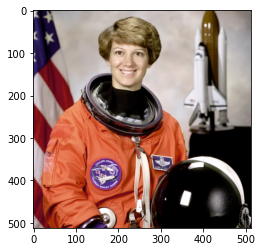

In [23]:
plt.imshow(im)
plt.show()

Les pixels sont numérotés à partir du pixel en haut à gauche et non en bas à gauche. Ce qui a pour conséquence d'inverser l'axe y lors d'un affichage.
Pour visualiser cela, commencez par afficher la fonction $\dfrac{x^2}{512}$ entre 0 et 512, puis faites la même chose en plaçant la fonction dans une figure où vous afficherez également l'image de Eileen Collins.

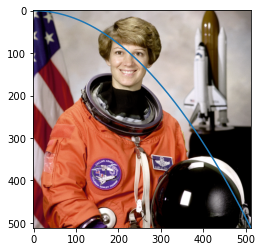

In [24]:
x = np.linspace(0, 512, 512, endpoint=True)
plt.plot(x,x*x/512)
plt.gca().invert_yaxis()
plt.imshow(im)
plt.show()

Il est possible d'inverser le sens de lecture de l'axe y en inversant les limites de l'axe:

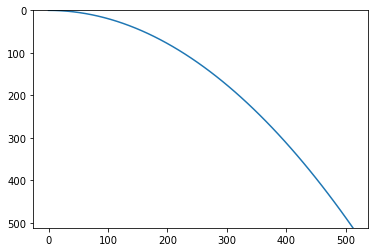

In [25]:
x = np.linspace(0,512)
fx = x**2/512
plt.plot(x,fx)
plt.ylim(np.max(fx),np.min(fx))
plt.show()

Il faut également faire attention à la convention d'accès aux points dans une image. Généralement on considère que la première dimension correspond à l'axe des abscisses et la deuxième à l'axe des ordonnées. Pour les images, on considère que la première dimension est le numéro de la ligne et le deuxième, l'axe des colonnes. La position du point (100,400) n'est donc donc pas au même endroit en fonction des deux conventions comme le code suivant:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


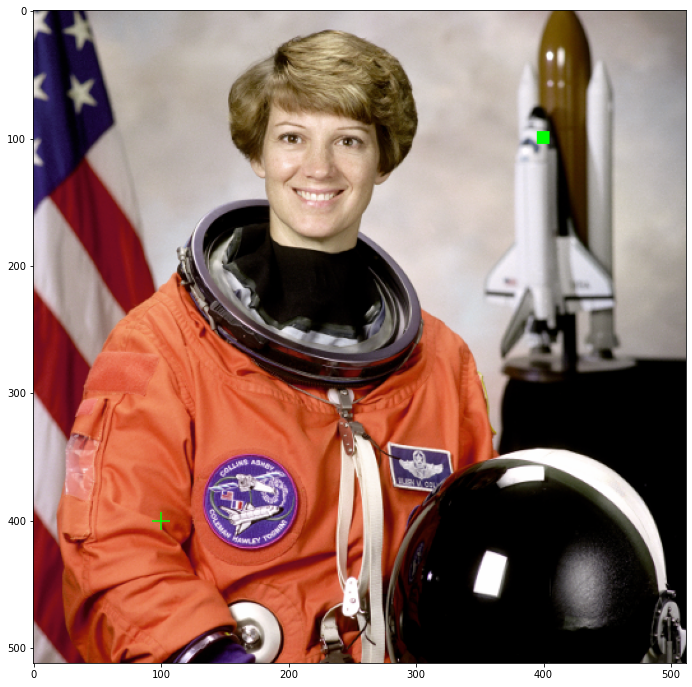

In [26]:
im2 = im.copy()
im2[95:105,395:405] = [0,255,0]
plt.figure(figsize=(12,12))
plt.scatter(100,400,c=[0,1,0],s=300,marker='+')
plt.imshow(im2)
plt.show()

### 1.2 - Application d'une transformation affine à une image

Pour appliquer une transformation à une image, un STN applique la transformation à une grille de points. La grille permet de faire le lien entre la position des pixels dans l'image d'origine et dans l'image transformée. Nous allons dans cette partie visualiser le mécanisme permettant de réaliser la transformation en le codant avec numpy. 

En utilisant la fonction `meshgrid` de `numpy` (https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.meshgrid.html ) générez une grille de (512,512) points 2D de (-1,-1) à (1,1). Vous nommerez les sorties de la fonction `meshgrid`:  `x_grille` et `y_grille`.

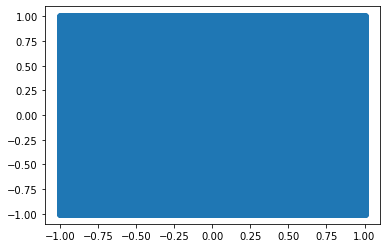

In [27]:
x = np.linspace(-1,1,512)
y = np.linspace(-1,1,512)
x_grille, y_grille = np.meshgrid(x,y)
plt.scatter(x_grille, y_grille)
plt.show()


Le code suivant affiche la grille de points générés à la question précédente (en n'affichant qu'un point sur 20). La ligne 0 est affichée en dégradé et l'axe y est inversé.

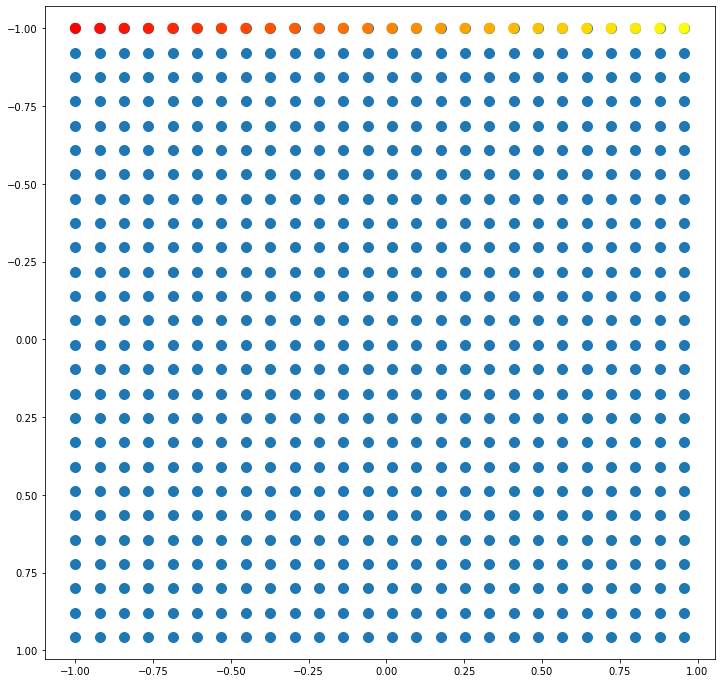

In [28]:
plt.figure(figsize=(12,12))
plt.scatter(x_grille[::20,::20],y_grille[::20,::20],s=100)
plt.scatter(
    x_grille[0,::20],
    y_grille[0,::20],
    c=np.linspace(0,1,512//20+1),
    cmap='autumn',
    s=100
)
plt.ylim(1,-1)
plt.axis('equal')
plt.show()

Concatenez la sortie de `np.meshgrid` et placez le résultat dans un tenseur nommé `grille1`. 

In [29]:
gx = torch.tensor(x_grille)
gy = torch.tensor(y_grille)
grille1 = torch.stack((gx, gy), 2)
print('Dimension de grille1:',grille1.shape)

Dimension de grille1: torch.Size([512, 512, 2])


Redimensionnez le tenseur `grille1` pour avoir un tenseur de taille $(512\times512,2)$ contenant la liste des points de la grille. Vous placerez le résultat dans un objet nommé `P_grille1`.

In [30]:
P_grille1 = torch.reshape(grille1, (512*512, 2))
print('Dimension de grille1:',grille1.shape)
print('Dimension de P_grille1:',P_grille1.shape)


Dimension de grille1: torch.Size([512, 512, 2])
Dimension de P_grille1: torch.Size([262144, 2])


Ajoutez une colonne de 1 à `P_grille1`.

In [31]:
A= torch.ones((512*512, 1))
P_grille1 = torch.cat(( P_grille1,A), 1)
print('Dimension de P_grille1:',P_grille1.shape)

Dimension de P_grille1: torch.Size([262144, 3])


Définissez une matrice de transformation $T$ composée du produit de trois matrices $B, R, S$ avec :
- $B$ une matrice de translation : $\left[\begin{array}{ccc}
1&0&t_0\\
0&1&t_1\\
0&0&1
\end{array}\right]
$
- $R$ une matrice de rotation : $\left[\begin{array}{ccc}
\cos(\theta)&-\sin(\theta)&0\\
\sin(\theta)&\cos(\theta)&0\\
0&0&1
\end{array}\right]
$
- $S$ une matrice de changement d'échelle:$\left[\begin{array}{ccc}
s&0&0\\
0&s&0\\
0&0&1
\end{array}\right]
$

Vous pouvez prendre $t=\dfrac{1}{3}\left[\begin{array}{c}
1\\
-1
\end{array}\right]
$, $\theta=\dfrac{\pi}{14}$, $s=2$.

In [32]:
# rotation
t = np.pi/14
R = np.array(( (np.cos(t), -np.sin(t), 0),
               (np.sin(t),  np.cos(t), 0),
               (0,0,1)))
# scale
s=2
S = np.array(( (s, 0, 0),
             (0,s, 0),
             (0,0,1)))

# translation
t=np.array((( 1/3),
           (-1/3)) , dtype=float)

B = np.array(( (1, 0, t[0]),
             (0,1, t[1]),
             (0,0,1)))

T = B @ R @ S

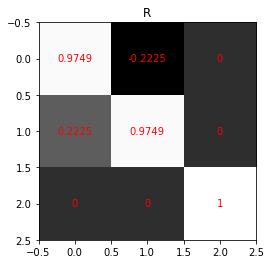

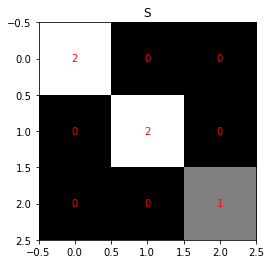

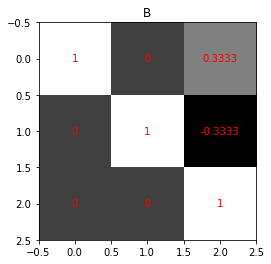

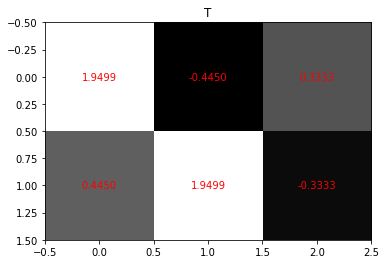

In [37]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(R,cmap='gray')
plt.title('R')
for (j,i),label in np.ndenumerate(R):
    if label==int(label):
        ax.text(i,j,int(label),ha='center',va='center',color='r')
    else:
        ax.text(i,j,"%0.4f"%label,ha='center',va='center',color='r')
        
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(S,cmap='gray')
plt.title('S')
for (j,i),label in np.ndenumerate(S):
    ax.text(i,j,int(label),ha='center',va='center',color='r')
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(B,cmap='gray')
plt.title('B')
for (j,i),label in np.ndenumerate(B):
    if label==int(label):
        ax.text(i,j,int(label),ha='center',va='center',color='r')
    else:
        ax.text(i,j,"%0.4f"%label,ha='center',va='center',color='r')
        
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(T,cmap='gray')
plt.title('T')
for (j,i),label in np.ndenumerate(T):
    if np.abs(label-int(label))<1e-4:
        ax.text(i,j,int(label),ha='center',va='center',color='r')
    else:
        ax.text(i,j,"%0.4f"%label,ha='center',va='center',color='r')
        
plt.show()

Supprimez la dernière ligne de la matrice `T`.

In [34]:
T = np.delete(T, (-1), axis=0)

Calculez le produit matriciel entre `P_grille1` et la transposée de la matrice de la question précédente. Vous stockerez le résultat dans un objet `P_grille0`.

In [35]:
P_grille0 = P_grille1 @ T.T

Redimensionnez `P_grille0` en un tenseur (512,512,2) que vous nommerez `grille0` et affichez les points de la grille tous les 20 points avec un dégradé de couleur pour la première ligne et l'axe y inversé. La grille `grille0` correspond à la grille `grille1` après application de la transformation `T`.

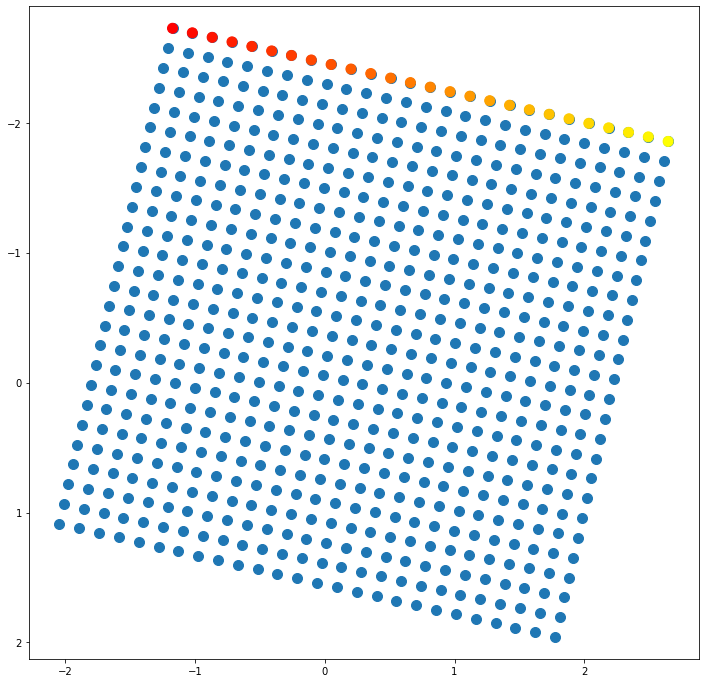

In [36]:
grille0 = torch.reshape(P_grille0, (512,512, 2))

plt.figure(figsize=(12,12))
plt.scatter(grille0[::20,::20,0],grille0[::20,::20,1],s=100)
plt.scatter(
    grille0[0,::20,0],
    grille0[0,::20,1],
    c=np.linspace(0,1,512//20+1),
    cmap='autumn',
    s=100
)
plt.ylim(1,-1)
plt.axis('equal')
plt.show()

Il est possible d'obtenir le même résultat directement avec PyTorch en utilisant la fonction `torch.nn.functional.affine_grid`. Il faut pour cela lui passer la transformation `T` et les dimensions de l'image. Attention les dimensions doivent être de (1,2,3) pour `T` et être au format PyTorch pour l'image.

C:\Users\ezzay\anaconda3\lib\site-packages\torch\nn\functional.py:4065: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


TypeError: scatter() got multiple values for argument 's'

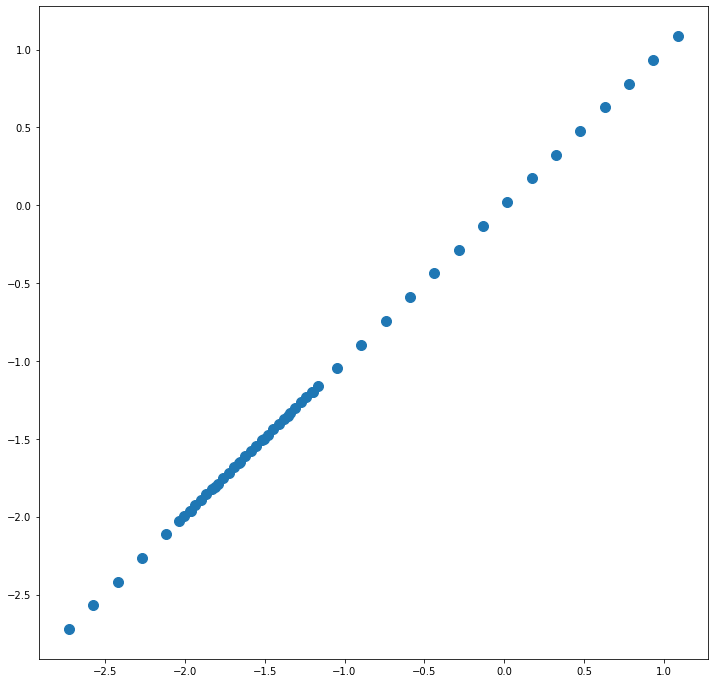

In [38]:
Ten = torch.tensor(T)
Ten = torch.reshape(Ten,(1,2,3))
Gridd = torch.nn.functional.affine_grid(Ten, (1,2,512,512))

plt.figure(figsize=(12,12))
plt.scatter(Gridd[::20,::20,0],Gridd[::20,::20,1],s=100)
plt.scatter(
    Gridd[0,::20,0],
    Gridd[0,::20,1],2,
    c=np.linspace(0,1,512//20+1),
    cmap='autumn',
    s=100
)
plt.ylim(1,-1)
plt.axis('equal')
plt.show()

Le code suivant permet de visualiser sur un même schéma l'effet de la transformation `T` sur la grille:

TypeError: max() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (Tensor other)
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


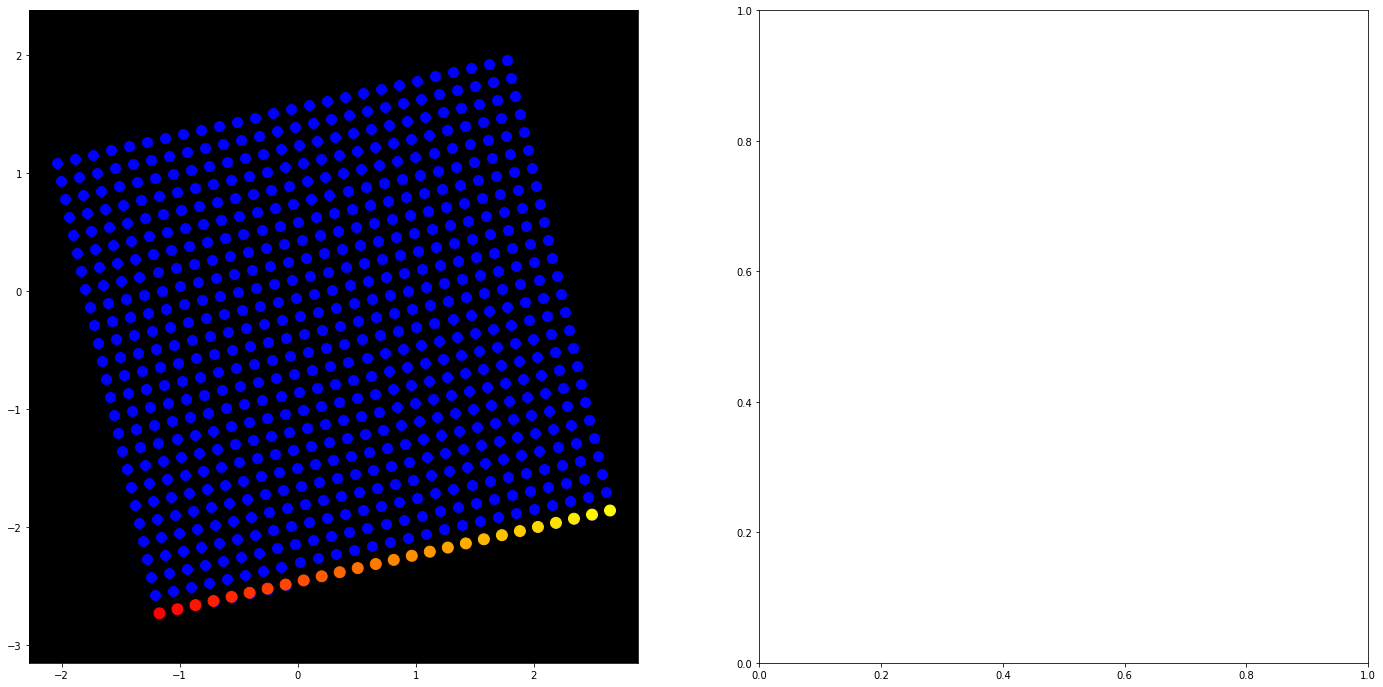

In [239]:
h = 20

# Affichage de la grille 0
_,axarr = plt.subplots(1,2, figsize=(24,12))
axarr[0].scatter(grille0[::h,::h,0],grille0[::h,::h,1],c='b',s=100)
axarr[0].scatter(grille0[0,::h,0],grille0[0,::20,1],c=np.linspace(0,1,512//20+1),cmap='autumn',s=120)
axarr[0].axis('equal')
axarr[0].set_facecolor((.0, 0., 0.)) # background en noir
axarr[0].set_ylim(np.max(grille0[:,:,1]),np.min(grille0[:,:,1])) #inversion de l'axe y

# Affichage de la grille 1
axarr[1].scatter(grille1[::h,::h,0],grille1[::h,::h,1],c='b',s=100)
axarr[1].scatter(grille1[0,::h,0],grille1[0,::20,1],c=np.linspace(0,1,512//20+1),cmap='autumn',s=120)
axarr[1].axis('equal')
axarr[1].set_facecolor((.0, 0., 0.))
axarr[1].set_ylim(np.max(grille1[:,:,1]),np.min(grille1[:,:,1]))

# Affichage des flèches
xy0 = [grille1[0,0,0],grille1[0,0,1]]
xy1 = [grille0[0,0,0],grille0[0,0,1]]
con = ConnectionPatch(xyA=xy0, xyB=xy1, coordsA="data", coordsB="data",
                      axesA=axarr[1], axesB=axarr[0], color="green",arrowstyle="<|-",lw=5,mutation_scale=40)
axarr[1].add_artist(con)

xy0 = [grille1[256,256,0],grille1[256,256,1]]
xy1 = [grille0[256,256,0],grille0[256,256,1]]
con = ConnectionPatch(xyA=xy0, xyB=xy1, coordsA="data", coordsB="data",
                      axesA=axarr[1], axesB=axarr[0], color="green",arrowstyle="<|-", lw=5,mutation_scale=40)
axarr[1].add_artist(con)

axarr[0].set_title('grille0')
axarr[1].set_title('grille1')
plt.show()

Pou appliquer la transformation T, on crée l'image de droite en parcourant les pixels de la grille 0 et en les plaçant à la position de la grille 1. Pour l'instant nous avons utilisé une grille de pixel centré en 0 et ayant des valeurs entre -1 et 1. Pour correspondre à notre image, il nous faut des valeurs de position des éléments de la grille 1 centrée en 256 et comprise entre 0 et 512. Appliquez aux deux grilles la même transformation pour que la grille 1 vérifie les conditions précédentes. Vous afficherez également l'image étudiée.

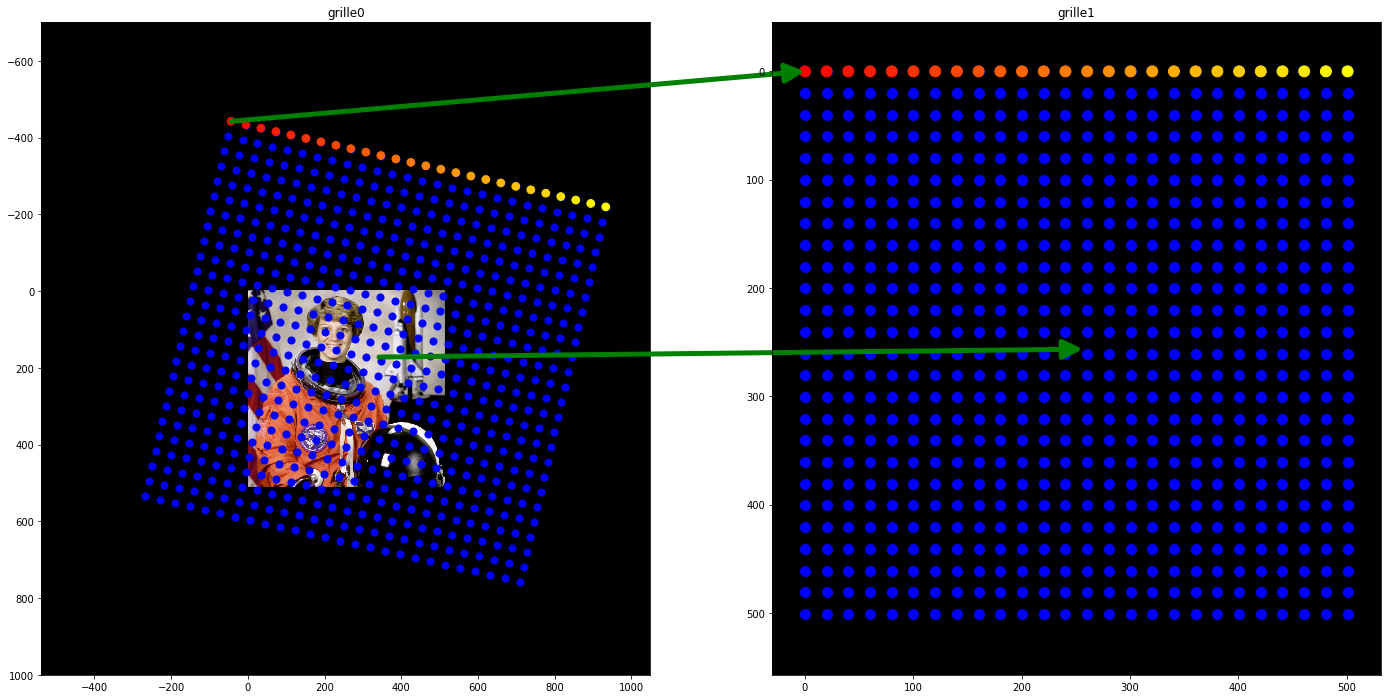

Complétez le code suivant permettant d'appliquer la transformation à l'image d'origine.

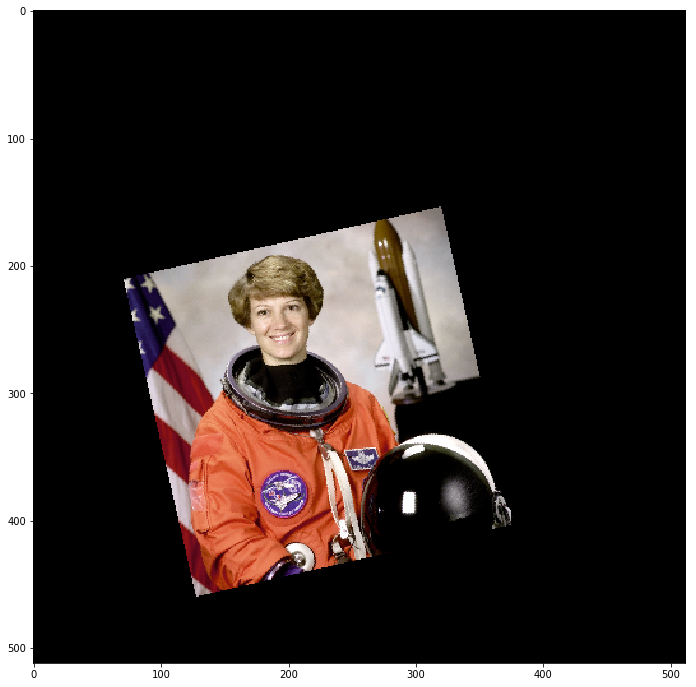

In [20]:
# Déclarez un tableau de 0 de taille (512,512,3)
im1 = ?

# Conversion des grilles en position de pixels dans les deux images. Les valeurs doivent être des entiers.
P_grille0_int = (P_grille0*?+?).astype(?)
P_grille1_int = (P_grille1*?+?).astype(?)

# Masque permettant de positionner les pixels de l'image d'origine correspondant à des valeurs de grille entre -1 et 1.
masque = (?<P_grille0[:,0]) *\
         (P_grille0[:,0]<1)*\
         (-1<P_grille0[:,1]) *\
         (P_grille0[:,1]<?)

# Positionnement des pixels dans la nouvelle image en utilisant les 2 grilles. Attention la convention entre les points et les images ne sont pas dans le même sens (cf. début du TP).
im1[?[masque,1],?[masque,0]] = ?[?[masque,1],?[masque,0],:]

# Affichage de l'image résultante
?
?
plt.show()

Affichez sur une même image l'image d'origine, l'image transformée et les grilles qui ont permis de faire la transformation.

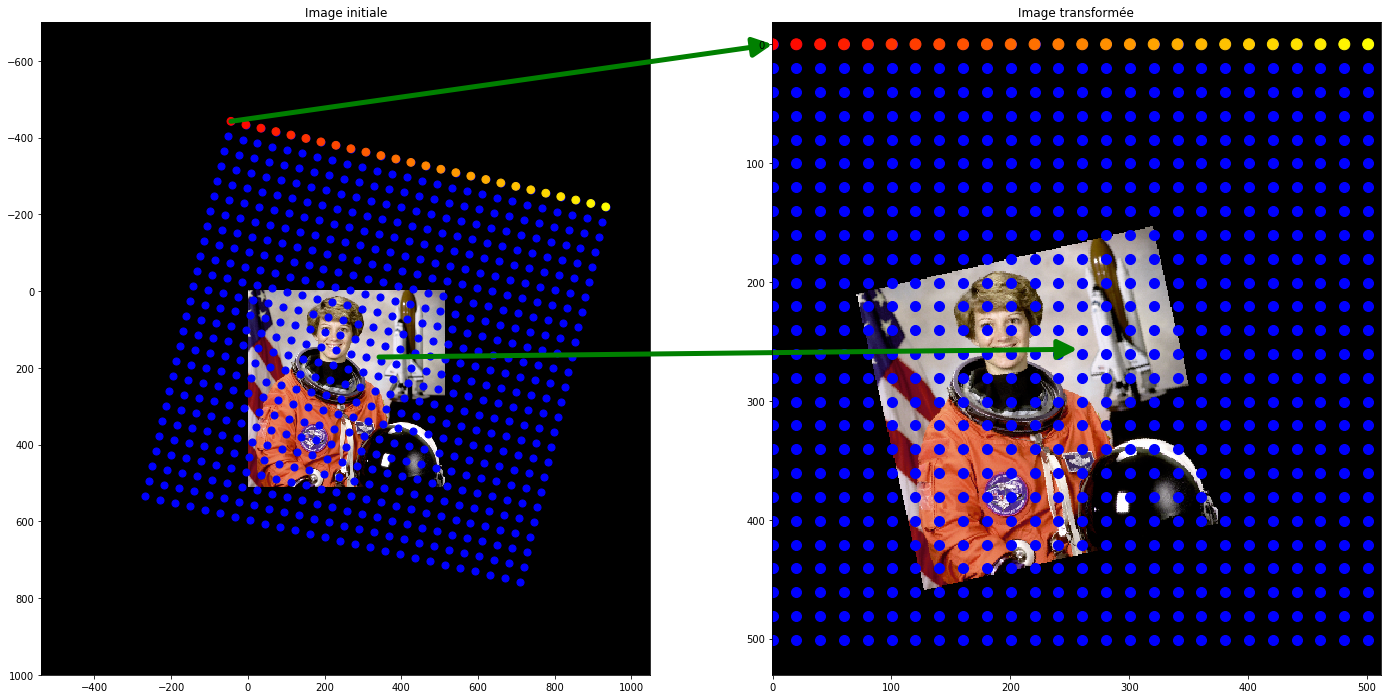

Il est possible de réaliser directement cette opération en PyTorch en utilisant la fonction `torch.nn.functional.grid_sample` après la fonction `torch.nn.functional.affine_grid` qui crée la grille. En utilisant ces deux fonctions faites en PyTorch l'équivalent des questions précédentes et affichez l'image transformée.

torch.Size([1, 512, 512, 2])
(4, 3, 19)


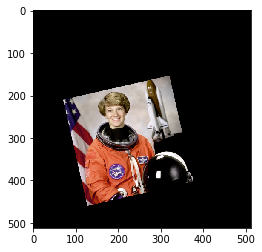

In [22]:
grid = ?
x = ?
?
plt.show()

2 - Utiliser un ResNet18 avec un STN sur la base GTSRB
------

En vous basant sur le TP précédent, faites un classifieur sur la base GTSRB à partir d'un ResNet18 pré-entrainé sur ImageNet auquel vous avez redéfini la dernière couche pour la ré-entrainer. 

Complétez le code suivant permettant d'effectuer un STN suivi d'un Resnet18.
Pour réaliser le STN vous aurez besoin de deux parties:
- un réseau estimant la transformation,
- un code appliquant la transformation aux images comme vues dans la partie précédente. 

Le réseau estimant la transformation sera un réseau convolutionnel dont l'architecture est la suivante: 
- Conv1(dimension de sortie:8,taille du noyau:7) - MaxPool(Stride:2, taille du noyau: 2) - Relu - 
- Conv2(dimension de sortie:10,taille du noyau:5) - MaxPool(Stride:2, taille du noyau: 2) - Relu - 
- FC1(dimension de sortie:32) - Relu - 
- FC2(dimension de sortie:6)

In [24]:
class SNT_Net(nn.Module):
    def __init__(self):
        super(SNT_Net, self).__init__()

        # Réseau estimant la transformation (partie convolutionnelle)
        self.conv_loc = nn.Sequential(
            ?,
            ?,
            ?,
            ?,
            ?,
            ?

        )

        #  Réseau estimant la transformation (partie entièrement connectée)
        self.fc_loc = nn.Sequential(
            ?,
            ?,
            ?
        )

        # On initialise le STN avec la transformation identité
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))
        
        self.resnet18 = resnet18

    # Application de la transformation sur des images
    def stn(self, x):
        # Calcul de la transformation pour chaque image de x
        # partie convolutionnelle
        xs = self.conv_loc(?)
        # Redimensionnement pour la partie FC
        xs = ?
        # Estimation des 6 paramètres de la transformation avec les couches FC
        theta = self.?(xs)
        # Redimensionnement en une transformation (2,3)
        theta = ?
        # Application de la transformation à l'aide d'une grille
        grid =?
        x = ?

        return x  
    
    def forward(self, x):
        # Calcul et application de la transformation pour chaque image
        x = ?

        # Utilisation du Resnet18 sur les données transformées
        x = ?
        
        return F.log_softmax(x, dim=1)


model = SNT_Net().to(device)

Apprenez le réseau précédent sur 5 époques. 

Epoch 0/4
----------
train Loss: 0.3503 Acc: 0.8926
test Loss: 0.1145 Acc: 1.0000
Epoch 1/4
----------
train Loss: 0.0278 Acc: 0.9982
test Loss: 0.0339 Acc: 1.0000
Epoch 2/4
----------
train Loss: 0.0153 Acc: 0.9994
test Loss: 0.0250 Acc: 1.0000
Epoch 3/4
----------
train Loss: 0.0077 Acc: 1.0000
test Loss: 0.0150 Acc: 1.0000
Epoch 4/4
----------
train Loss: 0.0066 Acc: 1.0000
test Loss: 0.0074 Acc: 1.0000
CPU times: user 24.5 s, sys: 10.4 s, total: 34.9 s
Wall time: 36.1 s


En utilisant la méthode `stn` de la variable `model` apprise dans la question précédente, visualisez l'effet du STN sur les images de la base GTSRB.

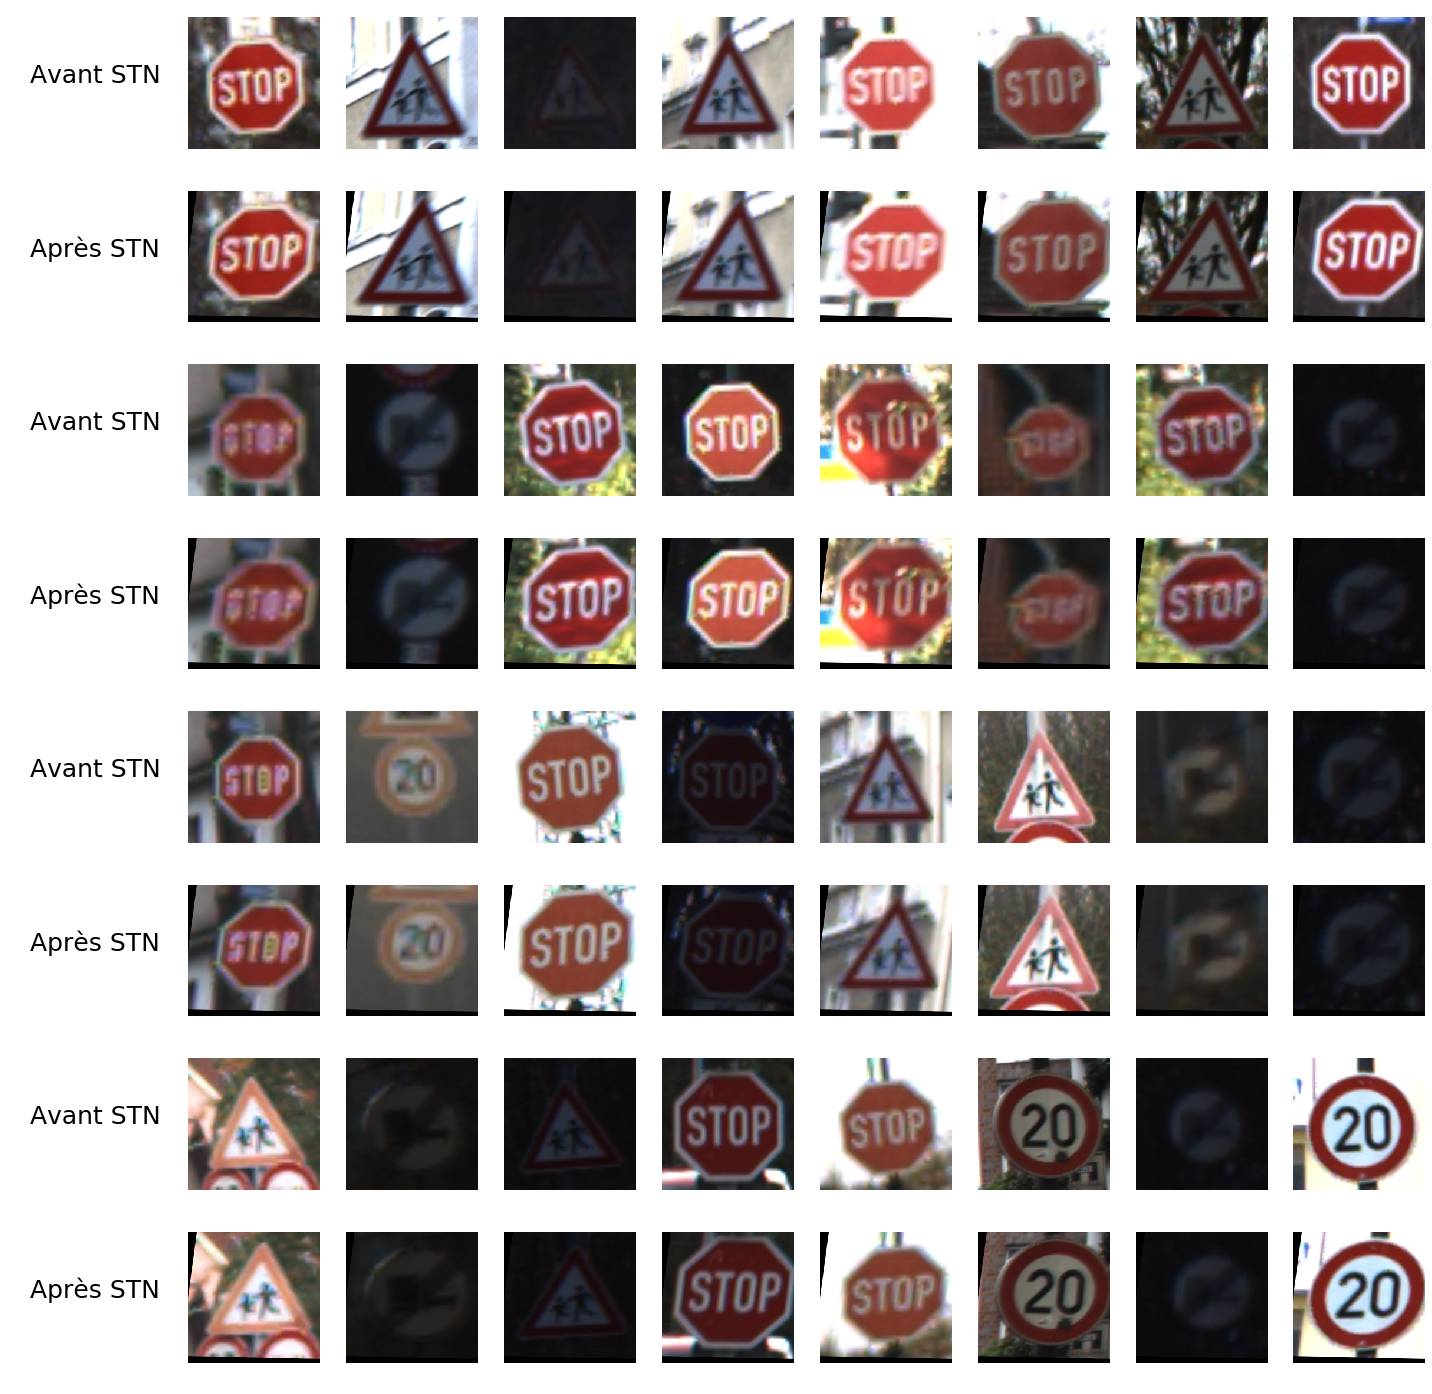